# Snow Cover

## Learning Objectives
In this tutorial, we will create a visualization of snow cover for Feb 15, 2023 and March 2, 2023, when an atmospheric river brought rain to the coastal and the Central Valley regions. When the water vapor moved up and over the Sierra Nevada mountain range, it rapidly cooled to form snow. Large amounts of snow were formed over the Sierra Nevada mountains.

## Dataset
We will use MODIS/Terra Snow Cover Daily L3 Global 0.05Deg CMG. This global Level-3 (L3) data set provides the percentage of snow-covered land and cloud-covered land observed daily, within 0.05° (approx. 5 km) MODIS Climate Modeling Grid (CMG) cells. 

The dataset and algorithm is described in the [data user guide](https://nsidc.org/sites/default/files/mod10c1-v061-userguide_0.pdf) and the [Product Specific Document](https://nsidc.org/sites/default/files/c61_modis_snow_user_guide.pdf). 

Please cite the dataset as:
> Hall, D. K. and G. A. Riggs. (2021). MODIS/Terra Snow Cover Daily L3 Global 0.05Deg CMG, Version 61. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/MODIS/MOD10C1.061.

## Requirements
1. **Compute environment**: This notebook can only be run in an AWS Cloud instance running in the `us-west-2` region.
2. **Earthdata Login**. An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.
3. **Additional Requirements**: This tutorial requires the following Python modules installed in your system: earthaccess. To install the necessary Python modules, you can run:
```bash
pip install -r earthaccess 
```

In [1]:
import earthaccess
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from os import path

### 1. Authentication
Access to NASA OPeNDAP requires NASA Earthdata authentication. We recommend authenticating your [Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/) information using the earthaccess python library as follows:

In [2]:
auth = earthaccess.login(strategy="netrc") # works if the EDL login already been persisted to a netrc
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/28/2023
Using .netrc file for EDL


### 2. Search
Using the dataset DOI, we will use the `earthaccess` module to search for dataset granules from February 24, 2023, and March 2, 2023.

In [3]:
# doi = '10.5067/MODIS/MOD02HKM.061' #LAADS DAAC files not accessible
doi = '10.5067/MODIS/MOD10C1.061' # MODIS Terra Snowcover

# search granules from Feb 15, 2023
date1 = "2023-02-15"
granules1 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date1, date1)
)

# search granules from March 02, 2023
date2 = "2023-03-02"
granules2 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date2, date2)
)

Granules found: 1
Granules found: 1


### 3. Download
Let's download the granules to the local environment. This is needed as direct access to HDF4 files that MODIS Collection 6.1 comes as is currently not supported. The `earthaccess` module manages the authentication that is required for accessing data.

In [4]:
earthaccess.download(granules1, local_path='.')
earthaccess.download(granules2, local_path='.')

 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File MOD10C1.A2023046.061.2023050111133.hdf already downloaded


PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File MOD10C1.A2023061.061.2023070101022.hdf already downloaded


PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD10C1.A2023061.061.2023070101022.hdf']

### 4. Prepare
Let's open the downloaded granules into a `rioxarray`. The variable `Day_CMG_Snow_Cover` provides daily percent snow in 5km grids. The variable `Snow_Spatial_QA` provides quality indicator for each grid: 0=best, 1=good, 2=ok, 3=poor, 4=other, 237=inland water, 239=ocean, 250=cloud obscured water 252=Antarctica mask, 253=not mapped, 254=no retrieval, and 255=fill. We will only use the grids with 0, 1, and 2 quality flags.

In [5]:
# open granule from Feb 15, 2023
g_temp1 = path.basename(granules1[0].data_links()[0])
if path.isfile(g_temp1):
    with rxr.open_rasterio(g_temp1) as modis:
        snow_cover1 = modis['Day_CMG_Snow_Cover'][:]
        snow_cover_qa1 = modis['Snow_Spatial_QA'][:]

# open granules from March 02, 2023
g_temp2 = path.basename(granules2[0].data_links()[0])
if path.isfile(g_temp2):
    with rxr.open_rasterio(g_temp2) as modis:
        snow_cover2 = modis['Day_CMG_Snow_Cover'][:]
        snow_cover_qa2 = modis['Snow_Spatial_QA'][:]

# keep only good quality cells
snow_cover_good1 = snow_cover1.where((snow_cover_qa1 >= 0) & (snow_cover_qa1 <= 2))
snow_cover_good2 = snow_cover2.where((snow_cover_qa2 >= 0) & (snow_cover_qa2 <= 2)) 

### 5. Plot

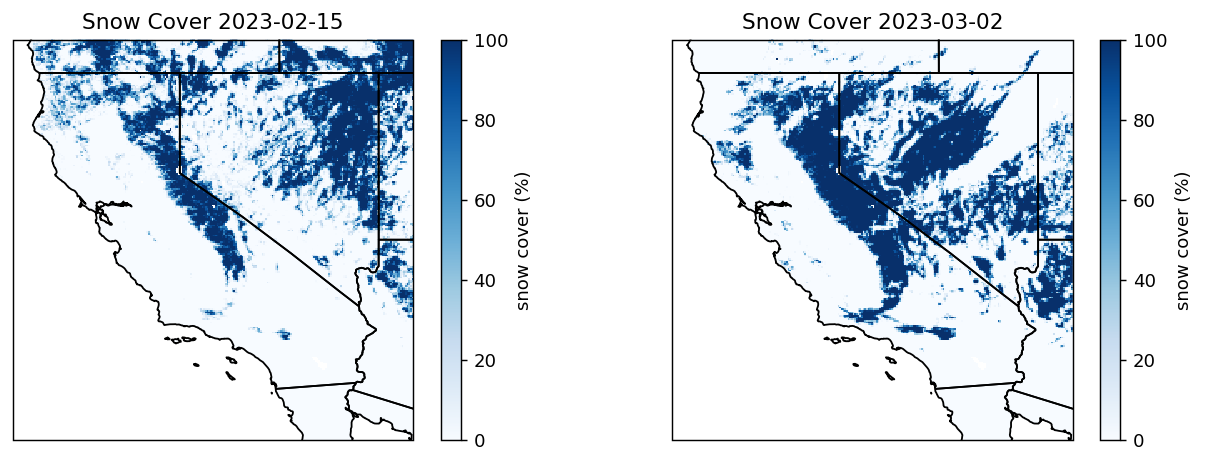

In [6]:
# create the plot
proj = ccrs.PlateCarree()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), dpi=130, facecolor="w", subplot_kw=dict(projection=proj))

# bounds of California
ca_bounds = [-125, -113.0, 31.0, 43.0]

snowax1 = ax1.pcolormesh(snow_cover_good1.x.values, snow_cover_good1.y.values, snow_cover_good1.values[0], vmax=100, cmap='Blues')
plt.colorbar(snowax1, ax=ax1, label="snow cover (%)")
ax1.add_feature(cfeature.STATES)
ax1.set_extent(ca_bounds, crs=proj)
ax1.set_title(f'Snow Cover {date1}')

snowax2 = ax2.pcolormesh(snow_cover_good2.x.values, snow_cover_good2.y.values, snow_cover_good2.values[0], vmax=100, cmap='Blues')
plt.colorbar(snowax2, ax=ax2, label="snow cover (%)")
ax2.add_feature(cfeature.STATES)
ax2.set_extent(ca_bounds, crs=proj)
ax2.set_title(f'Snow Cover {date2}')
plt.show()